In [1]:
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi
import operator
import pandas as pd
import deap.benchmarks.tools as bt

creator.create("obj", base.Fitness, weights=(-1.0,-1.0))
creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'control_variables': {'sine_a': {'min': 0.0, 'max': 2.0},
  'sine_b': {'min': 0.0, 'max': 1.57},
  'sine_c': {'min': 0.0, 'max': 6.28}},
 'evaluators': {'openmc_gc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_plank_openmc.py'],
   'execute2': [['aprun -n 1 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2'],
    ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ../../../../moltres/python/moltres_xs.py',
     'fhr_plank_gc.inp']],
   'inputs': ['sine_a', 'sine_b', 'sine_c'],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_plank_openmc_output.py'],
   'outputs': ['keff2', 'ppf'],
   'keep_files': 'only_final'},
  'moltres': {'order': 1,
   'input_script': ['aprun -n 20 -N 20 -d 1 -j 1 moltres-opt -i ',
    'fhr_plank_moltres.i'],
   'execute2': [],
   'inputs': [],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_plank_moltres_output.py'],
   'outputs': ['max_temp'],
   'keep_fil

In [4]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [5]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = logbook.select("gen")
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    print(obj_avg)
    print(np.diff(obj_avg))
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    print(obj_min)
    print(np.diff(obj_min))
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation", fontsize=20)
    ax.set_ylabel(obj_name, fontsize=20)
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.set_title(obj_name + " Evolution", fontsize=20)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight')

In [6]:
logbook = cp["logbook"]

[1180.829203223594, 1152.9522614448763, 1150.4415705421627]
[-27.87694178  -2.5106909 ]
[1127.4361331779, 1127.4361331779, 1127.4361331779]
[0. 0.]


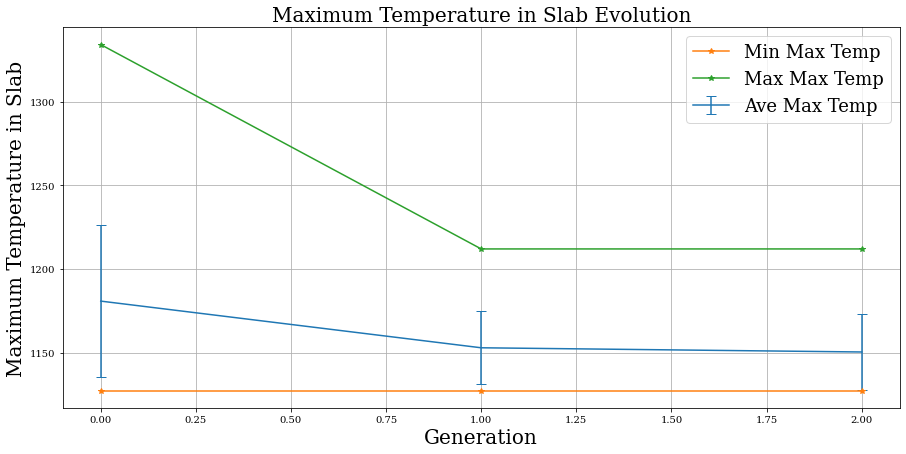

In [7]:
plot_1_obj(logbook, 0, "Maximum Temperature in Slab", "Max Temp", False, "slab-obj-2-tempppf-temp-evol.png")

[1.1366433842627492, 1.092155920351477, 1.0849678760825905]
[-0.04448746 -0.00718804]
[1.0638349983611735, 1.0638349983611735, 1.0593199744230914]
[ 0.         -0.00451502]


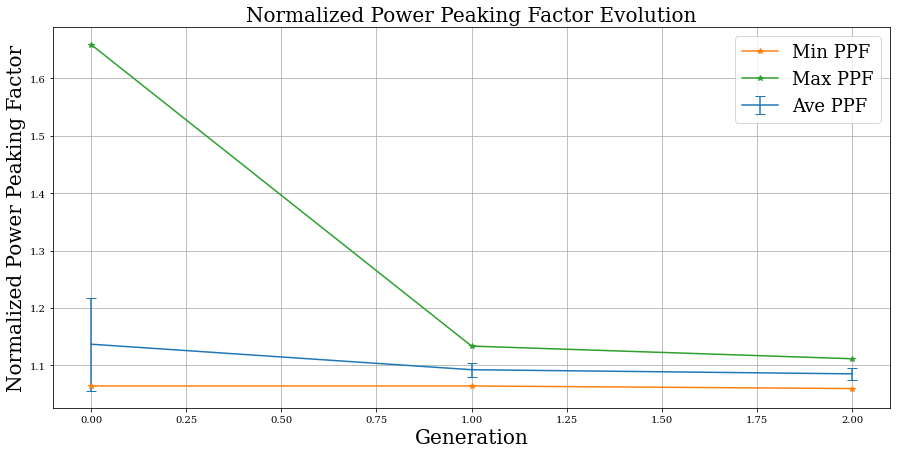

In [8]:
plot_1_obj(logbook, 1, "Normalized Power Peaking Factor", "PPF", False, "slab-obj-2-tempppf-ppf-evol.png")

[1.3580722342687233, 1.3527064286797557, 1.352663753368924]
[-5.36580559e-03 -4.26753108e-05]
[1.348895097079206, 1.3485636305477113, 1.3485636305477113]
[-0.00033147  0.        ]


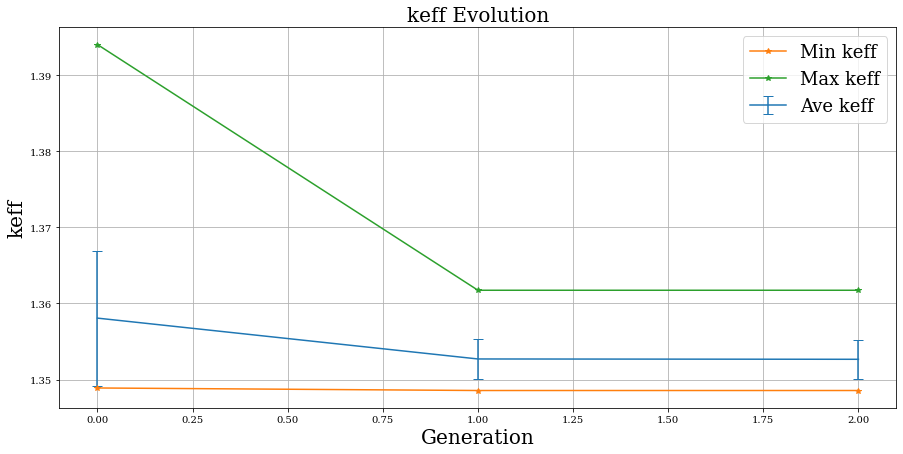

In [9]:
plot_1_obj(logbook, 2, "keff", "keff", False, "")

In [10]:
def sine_curve(ind, pf_present):
    if pf_present:
        pf, a, b, c = ind[0], ind[1], ind[2], ind[3]
    else:
        a, b, c = ind[0], ind[1], ind[2]
        pf = 0.0979
    boundaries = np.arange(2,27.1,2.31)
    midpoints = [] 
    for x in range(len(boundaries)-1):
        midpoints.append((boundaries[x]+boundaries[x+1])/2)
    midpoints = np.array(midpoints)
    x = midpoints
    x1 = np.arange(2, 24.8, 0.01)
    T_pitch = 0.09266
    vol_total = 23.1 * 2.55 * T_pitch * 20
    vol_triso = 4 / 3 * np.pi * 4235e-5 ** 3
    no_trisos = pf * vol_total / vol_triso
    vol_slice = 2.31 * 2.55 * T_pitch * 20
    sine = a * np.sin(b*x + c) + 2
    sine1 = a * np.sin(b*x1 + c) + 2
    sine1 = sine1 / sum(sine) * no_trisos * vol_triso / vol_slice
    sine = sine / sum(sine) * no_trisos * vol_triso / vol_slice
    return x, sine, x1, sine1 

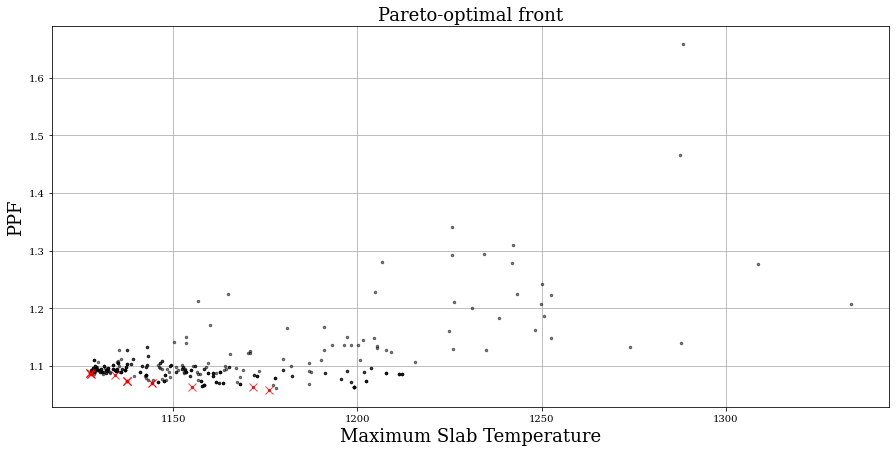

In [11]:
results = cp["all"]
all_pop = []
for p in results["populations"]:
    for i in p:
        all_pop.append(i)
non_dom_all = tools.sortNondominated(all_pop, k=len(all_pop), first_front_only=True)[0]

fig, ax = plt.subplots(figsize=(15,7))
for ind in all_pop:
    ax.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=5, alpha=0.5)
for ind in non_dom_all:
    ax.plot(ind.fitness.values[0], ind.fitness.values[1], 'rx', alpha=0.74, ms=8)
#ax.set_xlim(0.01, 0.10)
#ax.set_ylim(1.0, 1.6)
ax.set_ylabel('PPF',fontsize=18)
ax.set_xlabel('Maximum Slab Temperature',fontsize=18)
ax.set_title('Pareto-optimal front',fontsize=18)
ax.grid()

Text(0.5, 1.0, 'Pareto Front: TRISO Distribution')

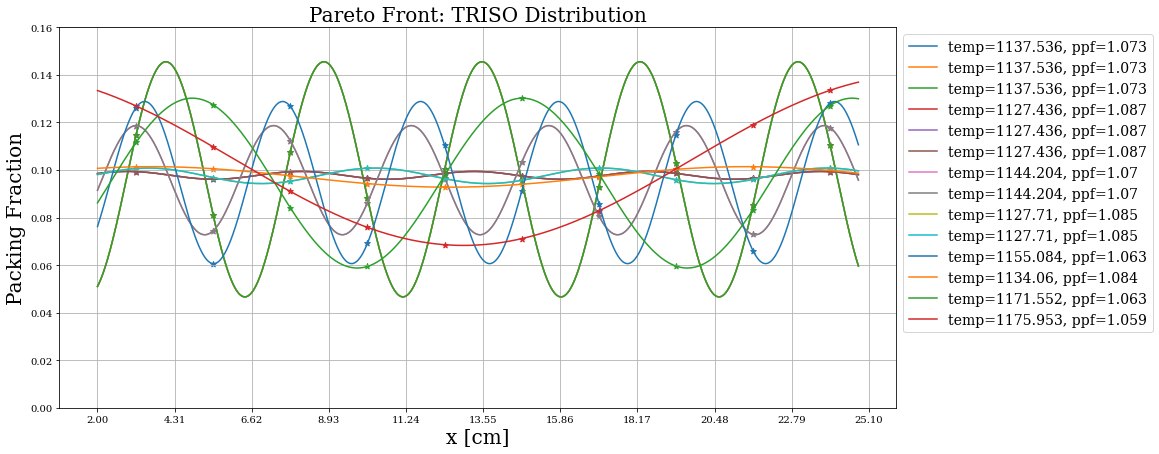

In [12]:
fig, ax = plt.subplots(figsize=(15,7))
for ind in non_dom_all:
    x, sine, x1, sine1 = sine_curve(ind, False)
    ax.scatter(x, sine, marker='*')
    ax.plot(x1, sine1, alpha=1, label="temp="+str(round(ind.fitness.values[0],3))+", ppf="+str(round(ind.fitness.values[1],3)))
ax.grid()
ax.set_ylim(0,0.16)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("Packing Fraction", fontsize=20)
ax.set_title('Pareto Front: TRISO Distribution', fontsize=20)

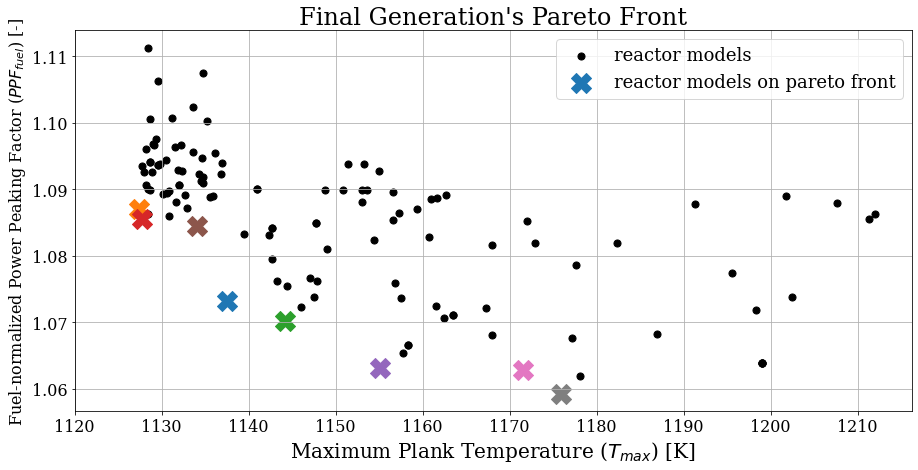

In [13]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig, ax = plt.subplots(figsize=(15,7))
count1, count2 = 0, 0
for ind in pop:
    if count1 == 0:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], marker='.', 
                   label="reactor models", s=200, color="black")
        count1 += 1
    else:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], marker='.', 
                   s=200, color="black")
        count1 += 1
for ind in non_dom:
    if count2 == 0:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], marker='X', 
                   s=400, label="reactor models on pareto front")
        count2 += 1
    else:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], marker='X', 
                   s=400)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks([1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210])
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylabel('Fuel-normalized Power Peaking Factor ($PPF_{fuel}$) [-]',fontsize=16)
ax.set_xlabel('Maximum Plank Temperature ($T_{max}$) [K]',fontsize=20)
ax.set_title("Final Generation's Pareto Front",fontsize=24)
ax.grid()
plt.savefig("slab-obj-2-tempppf-pareto",bbox_inches='tight', dpi=300)

TEMP, PPF 1 7
1 [0.03370948961467346, 1.2114794564969147, 4.334687778565412]
7 [0.6885561951033631, 0.23053835850619783, 1.7244765417016228]


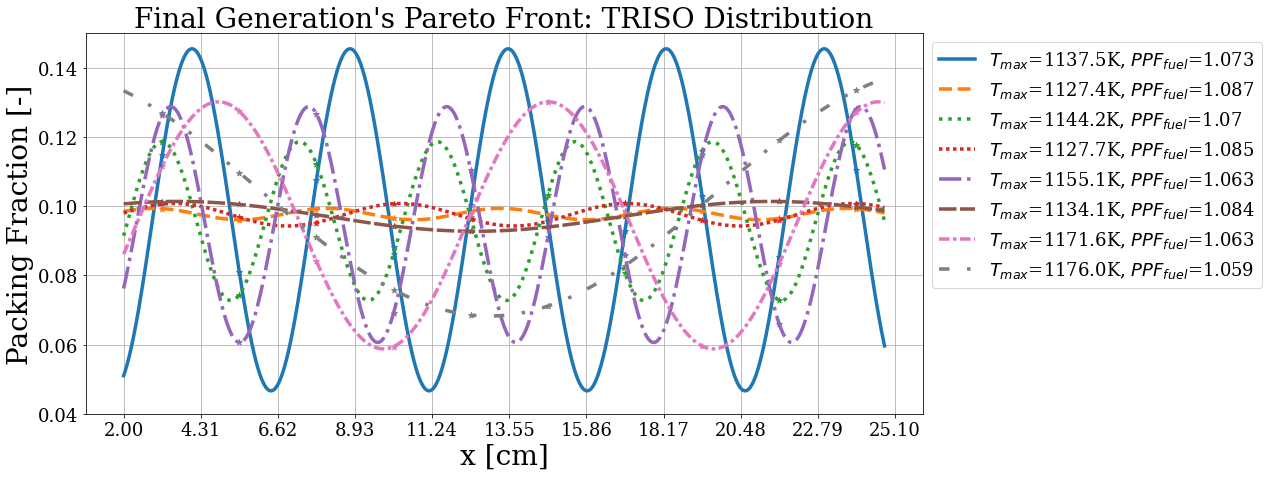

In [14]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
obj_0 = np.array([item.fitness.values[0] for item in non_dom])
obj_1 = np.array([item.fitness.values[1] for item in non_dom])
temp_min = np.argsort(obj_0)[0]
ppf_min = np.argsort(obj_1)[0]
print("TEMP, PPF", temp_min, ppf_min)
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
line_styles = ["-", "--", ":", (0, (1, 1)), "-.", (0, (5, 1)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5))]
fig, ax = plt.subplots(figsize=(15,7))
count = 0
for i, ind in enumerate(non_dom):
    if i in [ppf_min, temp_min]:
        print(i, ind)
        alpha = 1
    else:
        alpha = 1
    x, sine, x1, sine1 = sine_curve(ind, False)
    ax.scatter(x, sine, marker='*', alpha=alpha)
    ax.plot(x1, sine1, alpha=alpha, linestyle=line_styles[count], color=colors[count], linewidth=3.5, 
            label="$T_{max}$="+str(round(ind.fitness.values[0],1))+"K, $PPF_{fuel}$="+str(round(ind.fitness.values[1],3)))
    count += 1
ax.grid()
ax.set_ylim(0.04,0.15)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel("x [cm]", fontsize=28)
ax.set_ylabel("Packing Fraction [-]", fontsize=28)
ax.set_title("Final Generation's Pareto Front: TRISO Distribution", fontsize=28)
plt.savefig("slab-obj-2-tempppf-pareto-distr",bbox_inches='tight', dpi=300)

In [15]:
ref = np.array([1300,1.600])
for i, pop in enumerate(results["populations"]):
    non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    for ind in non_dom:
        ind.fitness.values = (ind.fitness.values[0], ind.fitness.values[1])
    hypervol = bt.hypervolume(non_dom, ref)
    print(i, hypervol)

0 92.04148766244126
1 92.08740737970855
2 92.75116900363652


In [18]:
checkpoint_file = "../../single-obj/p-1b/checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp2 = pickle.load(cp_file)

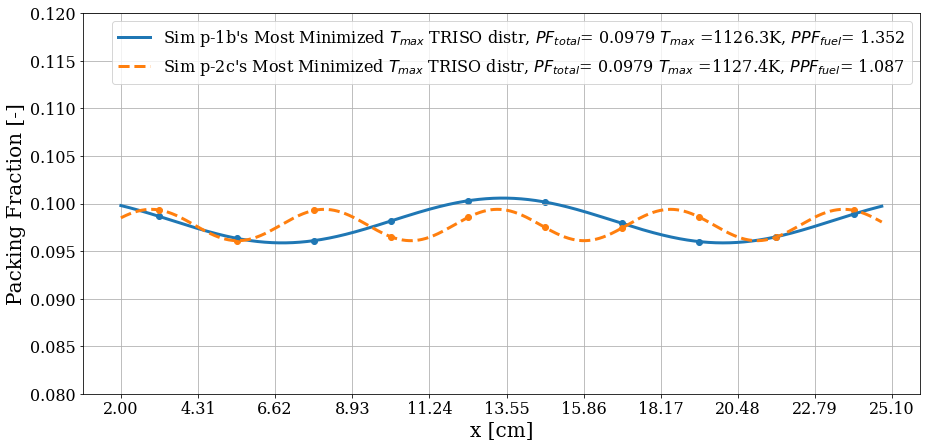

In [19]:
results_p1b = cp2["all"]
final_oup_p1b = results_p1b["outputs"][-1]
obj_0_p1b = np.array([item[0] for item in final_oup_p1b])
sorted_index_0_p1b = np.argsort(obj_0_p1b)
final_pop_p1b = results_p1b["populations"][-1]
fig, ax = plt.subplots(figsize=(15,7))
ind_p1b = final_pop_p1b[sorted_index_0_p1b[0]]
ind_p1b_sine = sine_curve(ind_p1b, False)
ax.scatter(ind_p1b_sine[0], ind_p1b_sine[1])
ax.plot(ind_p1b_sine[2], ind_p1b_sine[3], linewidth=3, linestyle=line_styles[0],
        label=r"Sim p-1b's Most Minimized $T_{max}$ TRISO distr, $PF_{total}$= "
        +str(0.0979)+" $T_{max}$ ="+str(round(ind_p1b.output[0],1)) 
        + "K, $PPF_{fuel}$= "+ str(round(ind_p1b.output[1],3)))

ind_p2c_pf = non_dom[temp_min] 
ind_p2c_pf_sine = sine_curve(ind_p2c_pf, False)
ax.scatter(ind_p2c_pf_sine[0], ind_p2c_pf_sine[1])
ax.plot(ind_p2c_pf_sine[2], ind_p2c_pf_sine[3], linewidth=3, linestyle=line_styles[1],
        label=r"Sim p-2c's Most Minimized $T_{max}$ TRISO distr, $PF_{total}$= "
        +str(0.0979)+" $T_{max}$ ="+str(round(ind_p2c_pf.output[0],1)) 
        + "K, $PPF_{fuel}$= "+ str(round(ind_p2c_pf.output[1],3)))

ax.grid()
ax.set_ylim(0.095,0.103)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=16, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.set_ylim(0.08, 0.12)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("Packing Fraction [-]", fontsize=20)
#ax.set_title("TRISO Distribution", fontsize=24)
plt.savefig("p-2c-p-1b-temp-most-minimized-comparison.png",bbox_inches='tight', dpi=300)

In [20]:
checkpoint_file = "../../single-obj/p-1c/checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp3 = pickle.load(cp_file)

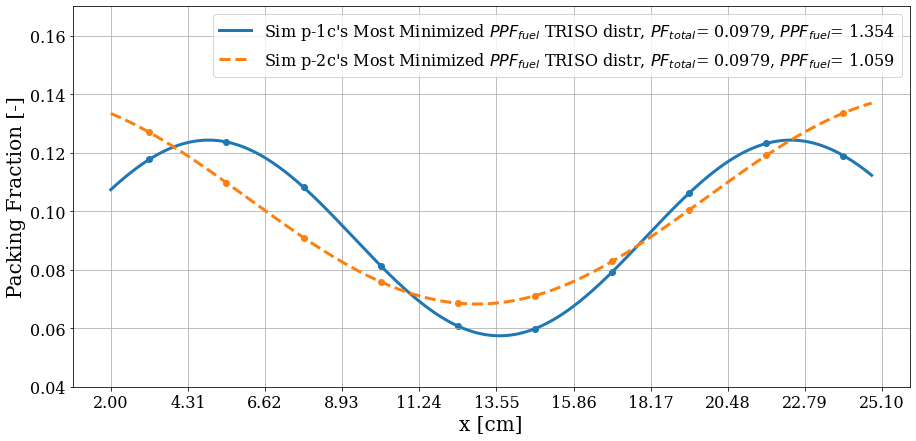

In [21]:
results_p1c = cp3["all"]
final_oup_p1c = results_p1c["outputs"][-1]
obj_0_p1c = np.array([item[0] for item in final_oup_p1c])
sorted_index_0_p1c = np.argsort(obj_0_p1c)
final_pop_p1c = results_p1c["populations"][-1]
fig, ax = plt.subplots(figsize=(15,7))
ind_p1c = final_pop_p1c[sorted_index_0_p1c[0]]
ind_p1c_sine = sine_curve(ind_p1c, False)
ax.scatter(ind_p1c_sine[0], ind_p1c_sine[1])
ax.plot(ind_p1c_sine[2], ind_p1c_sine[3], linewidth=3, linestyle=line_styles[0],
        label=r"Sim p-1c's Most Minimized $PPF_{fuel}$ TRISO distr, $PF_{total}$= "
        +str(0.0979) 
        + ", $PPF_{fuel}$= "+ str(round(ind_p1c.output[1],3)))

ind_p2c_ppf = non_dom[ppf_min] 
ind_p2c_ppf_sine = sine_curve(ind_p2c_ppf, False)
ax.scatter(ind_p2c_ppf_sine[0], ind_p2c_ppf_sine[1])
ax.plot(ind_p2c_ppf_sine[2], ind_p2c_ppf_sine[3], linewidth=3, linestyle=line_styles[1],
        label=r"Sim p-2c's Most Minimized $PPF_{fuel}$ TRISO distr, $PF_{total}$= "
        +str(0.0979)
        + ", $PPF_{fuel}$= "+ str(round(ind_p2c_ppf.output[1],3)))

ax.grid()
ax.set_ylim(0.04,0.17)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=16, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("Packing Fraction [-]", fontsize=20)
#ax.set_title("TRISO Distribution", fontsize=24)
plt.savefig("p-2c-p-1c-ppf-most-minimized-comparison.png",bbox_inches='tight', dpi=300)